In [1]:
import os
import sys
import glob
import time
import math
import argparse

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torchvision as vsn

from skimage.transform import resize

from models.nets import ResUNet
from utils.data_loaders import *
from utils.data_vis import plot_from_torch

from utils.evaluations import DiceLoss, calc_metric
from tqdm import tqdm_notebook
from kaggle_util import *
from utils.evaluations import FocalLoss2d, DiceLoss, get_iou_vector
import utils.lovasz_losses as L
import matplotlib.pyplot as plt

imsize = 128
batch_size = 2
gpu = 1
weight_folder = '../model_weights/best/'
debug = False
flip_tta = True
use_bool = True

device = torch.device("cuda:{}".format(gpu) if torch.cuda.is_available() else "cpu")

In [2]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted 
    (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b

    print(run_lengths)
    return run_lengths

In [3]:
weights = glob.glob(weight_folder + 'best_fix2_*.pth')
print('Found {} models'.format(len(weights)))

print(weights)
OUT_FILE = '../subm/averaged_{}_resunet_models.csv'.format(len(weights))



Found 5 models
['../model_weights/best/best_fix2_resunet_tgs_slt_fold-0.pth', '../model_weights/best/best_fix2_resunet_tgs_slt_fold-1.pth', '../model_weights/best/best_fix2_resunet_tgs_slt_fold-2.pth', '../model_weights/best/best_fix2_resunet_tgs_slt_fold-3.pth', '../model_weights/best/best_fix2_resunet_tgs_slt_fold-4.pth']


In [4]:
files = ['best_fix3_resunet_tgs_slt_fold-0.pth',
        'best_fix3_resunet_tgs_slt_fold-1.pth',
        'best_fix2_resunet_tgs_slt_fold-2.pth',
        'best_fix3_2_resunet_tgs_slt_fold-3.pth',
        'best_fix2_resunet_tgs_slt_fold-4.pth']

weights = ['../model_weights/best/' + f for f in files]

In [5]:
weights

['../model_weights/best/best_fix3_resunet_tgs_slt_fold-0.pth',
 '../model_weights/best/best_fix3_resunet_tgs_slt_fold-1.pth',
 '../model_weights/best/best_fix2_resunet_tgs_slt_fold-2.pth',
 '../model_weights/best/best_fix3_2_resunet_tgs_slt_fold-3.pth',
 '../model_weights/best/best_fix2_resunet_tgs_slt_fold-4.pth']

In [6]:
# get the loaders
test_loader = get_test_loader(imsize=imsize, batch_size=batch_size)

net = ResUNet(use_bool=use_bool)
torch.cuda.set_device(gpu)
cudnn.benchmark = True
net.cuda()

Found 18000 test images


ResUNet(
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (bn_in): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (encode_b): Sequential(
    (0): SEResNeXtBottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (se_module): SEModule(
        (avg_pool): AdaptiveAvgPool2d(out

In [7]:
def predict(net, data_loader, test_ids, all_blanks, averaged_mask_preds, averaged_bool_preds,
            use_bool = True, flip_tta = True, test=True):
    
    total = len(data_loader.dataset) / batch_size
    prog = tqdm_notebook(total = total)
    for batch_idx, data in enumerate(data_loader): 
        prog.update(1)
        test_imgs = data['img'].cuda(async=True)
        batch_ids = data['id']
        if test:
            blanks = data['blank']
        # get predictions
        preds = net(test_imgs)
        if use_bool:
            bool_preds = preds[1].sigmoid()
            preds = preds[0].sigmoid()
        else:
            preds = preds.sigmoid()

        if test and flip_tta:
            test_imgs_lr = data['img_lr'].cuda(async=True)
            preds_lr_ = net(test_imgs_lr)
            if use_bool:
                bool_lr = preds_lr_[1].sigmoid()
                preds_lr_ = preds_lr_[0].sigmoid()
                bool_preds = (bool_lr + bool_preds) / 2.
            else:
                preds_lr_ = preds_lr_.sigmoid()

            preds_lr = np.zeros((preds_lr_.size())).astype(np.float32)
            preds_lr = np.copy(preds_lr_.data.cpu().numpy()[:,:,:,::-1])

            preds = (preds + torch.from_numpy(preds_lr).cuda()) / 2.

        if w_idx == 0:
            #print(preds.size())
            test_ids.extend(batch_ids)
            if test:
                all_blanks.extend(blanks.data.cpu())
            averaged_mask_preds.append(preds.data.view(-1, imsize, imsize).cpu())
            if use_bool:
                #print(bool_preds)
                averaged_bool_preds.append(bool_preds.data.cpu())
        else:
            averaged_mask_preds[batch_idx] += preds.data.view(-1, imsize, imsize).cpu()
            averaged_bool_preds[batch_idx] += bool_preds.data.cpu()
            
    return test_ids, all_blanks, averaged_mask_preds, averaged_bool_preds

In [8]:
val_msks = []
val_bools = []
val_blanks = []
test_ids = []
averaged_mask_preds = []
averaged_bool_preds = []
all_blanks = []
for w_idx, wf in tqdm_notebook(enumerate(weights)):
    print('Doing model {} of {}'.format(w_idx+1, len(weights)))
    
    train_loader, valid_loader = get_data_loaders(imsize=imsize,
                                                      batch_size=batch_size,
                                                      num_folds=5,
                                                      fold=w_idx)
    
    net.load_state_dict(torch.load(wf,map_location=lambda storage, loc: storage))
    net.eval() 
    net.to(device)
    
#     _, val_blanks, val_msks, val_bools =\
#         predict(net, valid_loader, [], val_blanks, val_msks, val_bools, flip_tta=False, test=False)
    
    test_ids, all_blanks, averaged_mask_preds, averaged_bool_preds =\
        predict(net, test_loader, test_ids, all_blanks, averaged_mask_preds, averaged_bool_preds)

Doing model 1 of 5


/home/kownse/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Doing model 2 of 5


Doing model 3 of 5


Doing model 4 of 5


Doing model 5 of 5


In [9]:
use_bool = False
#bool_thresh = 0.52
#msk_thresh = 0.46
bool_thresh = 0.5
msk_thresh = 0.4

avg_preds = torch.cat(averaged_mask_preds, dim=0)
#print(avg_preds)
avg_preds /= float(len(weights))
#print(avg_preds)
print(avg_preds.size())

# set masks to 0 with low probability of having mask 
if use_bool:
    bool_preds = torch.cat(averaged_bool_preds, dim=0)
    #print(bool_preds)
    bool_preds /= float(len(weights))
    bool_preds = bool_preds > bool_thresh
    print('number of non-empty predicted masks', bool_preds.sum())
    #print(bool_preds.size())
    avg_preds *= bool_preds.view(bool_preds.size(0),1,1).expand_as(avg_preds).float()

blanks = torch.Tensor(all_blanks).view(-1,1,1)
print('blanks', blanks.size())
avg_preds *= blanks.expand_as(avg_preds).float()

pred_np = avg_preds.cpu().numpy()

print(pred_np.shape)

# keep track of losses
rles = []
ids = []
for j in tqdm_notebook(range(pred_np.shape[0])):
    if imsize == 256:
        predicted_mask = resize(pred_np[j][27:229, 27:229], (101,101),
                                preserve_range=True)
    else:
        predicted_mask = pred_np[j][13:114, 13:114]
        predicted_mask = np.where(predicted_mask > msk_thresh, 1, 0)
        rles.append(RLenc(predicted_mask.astype(np.int32)))
        ids.append(test_ids[j])

print(len(ids), len(rles))
#print({'id':ids[:4], 'rle_mask':rles[:4]})

subm = pd.DataFrame.from_dict({'id':ids, 'rle_mask':rles}, orient='index').T

save_result(subm, '../subm/seresnet_bool_fix3.csv', 
                        competition = 'tgs-salt-identification-challenge', 
                        send = True, index = False)

torch.Size([18000, 128, 128])
blanks torch.Size([18000, 1, 1])
(18000, 128, 128)


18000 18000
save result
upload result
cmd: kaggle competitions submit -c tgs-salt-identification-challenge -f ../subm/seresnet_bool_fix3.csv.7z -m "submit"


In [8]:
def get_iou_vector(A, B, threshold = 0.5):
    batch_size = A.shape[0]
    B = np.where(B > threshold, 1, 0)
    metric = []
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        if np.count_nonzero(t) == 0 and np.count_nonzero(p) > 0:
            metric.append(0)
            continue
        if np.count_nonzero(t) >= 1 and np.count_nonzero(p) == 0:
            metric.append(0)
            continue
        if np.count_nonzero(t) == 0 and np.count_nonzero(p) == 0:
            metric.append(1)
            continue

        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = np.sum(intersection > 0) / np.sum(union > 0)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

focal_loss = FocalLoss2d()
bce = nn.BCEWithLogitsLoss()

def valid(net, valid_loader, threshold = 0.5, lambda_bool = 0.5, use_lovasz=True):
    net.eval() 
    # keep track of losses
    val_ious = []
    val_iter_loss = 0.
    # no gradients during validation
    with torch.no_grad():
        for i, data in enumerate(valid_loader):
            
            valid_imgs = data['img'].to(device)
            valid_msks = data['msk'].to(device)
            valid_msk_bool = data['has_msk'].float().to(device)
            # get predictions
            msk_vpreds, bool_vpreds = net(valid_imgs)
            msk_blend_vpreds = msk_vpreds * bool_vpreds.view(valid_imgs.size(0), 1, 1, 1)

            # calculate loss
            if use_lovasz:
                vloss = L.lovasz_hinge(msk_vpreds, valid_msks)
                #vloss += focal_loss(msk_vpreds, valid_msks)
                #vloss -= dice(msk_vpreds.sigmoid(), valid_msks)
            else:
                vloss = focal_loss(msk_vpreds, valid_msks)
                vloss += L.lovasz_hinge(msk_vpreds, valid_msks)
                #vloss -= dice(msk_vpreds.sigmoid(), valid_msks)
            
            vloss += lambda_bool * bce(bool_vpreds, valid_msk_bool.view(-1,1))
            vloss += lambda_bool * focal_loss(msk_blend_vpreds, valid_msks)

            #vloss += args.lambda_dice * dice(msk_vpreds.sigmoid(), valid_msks)
            # get validation stats
            val_iter_loss += vloss.item()
            
            val_ious.append(get_iou_vector(valid_msks.cpu().numpy()[:,:,13:114, 13:114], 
                                           msk_vpreds.sigmoid().cpu().numpy()[:,:,13:114, 13:114],
                                          threshold))
            
    epoch_vloss = val_iter_loss / (len(valid_loader.dataset) / batch_size)
    print('Avg Eval Loss: {:.4}, Avg IOU: {:.4}'.format(epoch_vloss, np.mean(val_ious)))
    return epoch_vloss, np.mean(val_ious)

In [9]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in


    true_objects = 2
    pred_objects = 2

    #  if all zeros, original code  generate wrong  bins [-0.5 0 0.5],
    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))

    intersection = temp1[0]

    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
      
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [10]:
def predict_img(net, valid_loader):
    net.eval() 
    # keep track of losses
    msk_preds = []
    bool_preds = []
    tar_msks = []
    # no gradients during validation
    with torch.no_grad():
        total = len(valid_loader.dataset) / batch_size
        prog = tqdm_notebook(total = total)
        for i, data in enumerate(valid_loader):
            prog.update(1)
            
            valid_imgs = data['img'].to(device)
            valid_msks = data['msk'].to(device)
            valid_msk_bool = data['has_msk'].float().to(device)
            # get predictions
            msk_vpreds, bool_vpreds = net(valid_imgs)
            msk_vpreds = msk_vpreds.sigmoid()
            bool_vpreds = bool_vpreds.sigmoid()
        
            msk_preds.append(msk_vpreds.data.view(-1, imsize, imsize).cpu().numpy())
            bool_preds.append([val.data.cpu().numpy() for val in bool_vpreds])
            tar_msks.append(data['msk'])
            
            
    tar_msks = np.concatenate(tar_msks, axis= 0)
    msk_preds = np.concatenate(msk_preds, axis= 0)
    bool_preds = np.concatenate(bool_preds, axis= 0)
            
    return tar_msks, msk_preds, bool_preds



In [11]:
use_lovasz = True
best_ious = []

tot_msk_preds = []
tot_bool_preds = []
tot_tar_msks = []

In [12]:

for fold, wf in tqdm_notebook(enumerate(weights)):
    print('Doing model {} of {}'.format(fold+1, len(weights)), wf)

    #if fold > 0:
    #    break

    # set model filenames
    train_loader, valid_loader = get_data_loaders(imsize=imsize,
                                                      batch_size=batch_size,
                                                      num_folds=5,
                                                      fold=w_idx)
    
    net = ResUNet(use_bool=True)
    net.load_state_dict(torch.load(wf,map_location=lambda storage, loc: storage))
    net.eval() 
    net.to(device)
    
    tar_msks, msk_preds, bool_preds = predict_img(net, valid_loader)

    tot_msk_preds.append(msk_preds)
    tot_bool_preds.append(bool_preds)
    tot_tar_msks.append(tar_msks)
    
tar_msks = np.concatenate(tot_tar_msks, axis= 0)
msk_preds = np.concatenate(tot_msk_preds, axis= 0)
bool_preds = np.concatenate(tot_bool_preds, axis= 0)

Doing model 1 of 5 ../model_weights/best/best_fix2_resunet_tgs_slt_fold-0.pth


/home/kownse/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Doing model 2 of 5 ../model_weights/best/best_fix2_resunet_tgs_slt_fold-1.pth


Doing model 3 of 5 ../model_weights/best/best_fix2_resunet_tgs_slt_fold-2.pth


Doing model 4 of 5 ../model_weights/best/best_fix2_resunet_tgs_slt_fold-3.pth


Doing model 5 of 5 ../model_weights/best/best_fix2_resunet_tgs_slt_fold-4.pth


In [13]:
bool_preds.max()

0.9998234

Threshold vs IoU (0.5263157894736842, 0.9439500000000001)


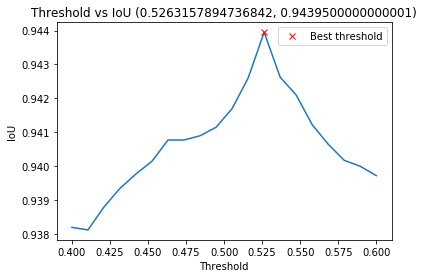

In [14]:
thresholds = np.linspace(0.4, 0.6, 20)
ious = np.array([iou_metric_batch(tar_msks, msk_preds > threshold) for threshold in tqdm_notebook(thresholds)])
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
title = "Threshold vs IoU ({}, {})".format(threshold_best, iou_best)
print(title)
plt.title(title)
plt.legend()


In [15]:
iou_metric_batch(tar_msks, msk_preds > 0.5)

0.874125

In [ ]:
tot_best_iou = 0
tot_best_threshold = 0
tot_best_bool_threshold = 0

bool_msk_ious = []
bool_thresholds = np.linspace(0.5, 0.9, 20)
for bool_thred in tqdm_notebook(bool_thresholds):
    bool_binary = (bool_preds > bool_thred) * 1
    bool_msk = np.zeros_like(msk_preds)
    for i in range(msk_preds.shape[0]):
        bool_msk[i] = msk_preds[i] * bool_binary[i]
        
    thresholds = np.linspace(0.445, 0.445, 1)
    ious = np.array([iou_metric_batch(tar_msks, bool_msk > threshold) for threshold in tqdm_notebook(thresholds)])
    threshold_best_index = np.argmax(ious) 
    iou_best = ious[threshold_best_index]
    threshold_best = thresholds[threshold_best_index]
    
    bool_msk_ious.append(ious)
    
    if iou_best > tot_best_iou:
        tot_best_threshold = threshold_best
        tot_best_bool_threshold = bool_thred
        tot_best_iou = iou_best
        print('new best iou', iou_best, tot_best_threshold, tot_best_bool_threshold)

In [ ]:
avg_bool = np.concatenate([val.data.cpu().numpy() for val in averaged_bool_preds], axis=0)

In [ ]:
avg_bool /= float(len(weights))

In [ ]:
avg_bool.max()